In [1]:
server = 'http://data.cropmap.edina.ac.uk'
server_url = server+"/clipped/fields"
shape_file = "fields.shp"

In [2]:
import rasterio
from rasterio.plot import show
import numpy as np
import os
from shapely.geometry import box
import geopandas as gpd
from fiona.crs import from_epsg
from rasterio.mask import mask
import pycrs
from matplotlib import pyplot
from rasterio.plot import show_hist
import geopandas as gpd
from shapely.geometry import mapping
from rasterio.mask import mask
from rasterio.plot import plotting_extent
from bs4 import BeautifulSoup
import requests

### Get all field files

Build an Array (fields) of Array (field files) of Dictionary (field info).

In [8]:
# One way to go through each tif files on the serveur

all_field_files = []
ext = 'tif'

def listTiffFiles(url, ext=''):
    page = requests.get(url).text
    #print(page)
    soup = BeautifulSoup(page, 'html.parser')
    return [url + '/' + node.get('href') for node in soup.find_all('a') if node.get('href').endswith(ext)]

def listDirs(url):
    page = requests.get(url).text
    #print(page)
    soup = BeautifulSoup(page, 'html.parser')
    return [url + '/' + node.get('href') for node in soup.find_all('a') 
            if node.get('href').endswith('/') and node.text != "Parent Directory"]

for dir in listDirs(server_url):
    url_elems = dir.split("/")
    field_id = url_elems[len(url_elems)-2]
    field = {
        "id": int(field_id)
    }
    files = []
    
    if(field["id"] == 0):
        for file_url in listTiffFiles(dir, ext):
            print(file_url)
            filename = file_url[file_url.rfind("/")+1:]
            file_elem = filename.split("_")
            date = file_elem[1]
            year = date[0:4]
            month = date[4:6]
            day = date[6:8]
            time_start = file_elem[2]
            time_end = file_elem[3]
            file_info = {
                "year": year,
                "month": month,
                "day": day,
                "start": time_start,
                "end": time_end,
                "url": file_url                    
            }
            files.append(file_info)
        field["files"] = files
        all_field_files.append(field)
all_field_files

http://data.cropmap.edina.ac.uk/clipped/fields/0//clipped_20180107_175836_175901.tif
http://data.cropmap.edina.ac.uk/clipped/fields/0//clipped_20180113_175748_175813.tif
http://data.cropmap.edina.ac.uk/clipped/fields/0//clipped_20180113_175813_175838.tif
http://data.cropmap.edina.ac.uk/clipped/fields/0//clipped_20180119_175836_175901.tif
http://data.cropmap.edina.ac.uk/clipped/fields/0//clipped_20180125_175748_175813.tif
http://data.cropmap.edina.ac.uk/clipped/fields/0//clipped_20180125_175813_175838.tif
http://data.cropmap.edina.ac.uk/clipped/fields/0//clipped_20180131_175835_175900.tif
http://data.cropmap.edina.ac.uk/clipped/fields/0//clipped_20180206_175748_175813.tif
http://data.cropmap.edina.ac.uk/clipped/fields/0//clipped_20180206_175813_175838.tif
http://data.cropmap.edina.ac.uk/clipped/fields/0//clipped_20180212_175835_175900.tif
http://data.cropmap.edina.ac.uk/clipped/fields/0//clipped_20180218_175747_175812.tif
http://data.cropmap.edina.ac.uk/clipped/fields/0//clipped_2018021

[{'id': 0,
  'files': [{'year': '2018',
    'month': '01',
    'day': '07',
    'start': '175836',
    'end': '175901.tif',
    'url': 'http://data.cropmap.edina.ac.uk/clipped/fields/0//clipped_20180107_175836_175901.tif'},
   {'year': '2018',
    'month': '01',
    'day': '13',
    'start': '175748',
    'end': '175813.tif',
    'url': 'http://data.cropmap.edina.ac.uk/clipped/fields/0//clipped_20180113_175748_175813.tif'},
   {'year': '2018',
    'month': '01',
    'day': '13',
    'start': '175813',
    'end': '175838.tif',
    'url': 'http://data.cropmap.edina.ac.uk/clipped/fields/0//clipped_20180113_175813_175838.tif'},
   {'year': '2018',
    'month': '01',
    'day': '19',
    'start': '175836',
    'end': '175901.tif',
    'url': 'http://data.cropmap.edina.ac.uk/clipped/fields/0//clipped_20180119_175836_175901.tif'},
   {'year': '2018',
    'month': '01',
    'day': '25',
    'start': '175748',
    'end': '175813.tif',
    'url': 'http://data.cropmap.edina.ac.uk/clipped/fields/0

In [11]:
def show_field_images(id=0, type="mask"):
    shapefile = gpd.read_file('fields.shp')
    
    num_row = 7
    num_col = 5
    num_file = num_row * num_col

    fig, axes = pyplot.subplots(num_row, num_col, figsize=(30,50))    
    
    for i, field in enumerate(all_field_files):
        field_id = field["id"]
        if(field_id == id):
            for i, file_info in enumerate(field["files"]):
                #print(file_info["url"])
                clipped = rasterio.open(file_info["url"])
                row = int(i/num_col)
                col = i % num_col

                if(type == 'crop'):
                    field_geojson = mapping(shapefile['geometry'][field_id])
                    field_crop, field_crop_affine = mask(clipped, [field_geojson], crop=True, indexes=[1])
                    # Create spatial plotting extent for the cropped layer
                    field_extent = plotting_extent(field_crop[0], field_crop_affine)
                    image = axes[row][col].imshow(field_crop[0],
                                      extent=field_extent,
                                      cmap='gist_earth')
                    fig.colorbar(image, ax=axes[row][col], orientation='vertical');
                else:
                    show(clipped, ax=axes[row][col])
                    shapefile[id:id+1].plot(ax=axes[row][col], color='red', alpha=0.8)

                axes[row][col].set_title("{}-{}-{} {}-{}"
                                         .format(
                                             file_info["year"],
                                             file_info["month"],
                                             file_info["day"],
                                             file_info["start"],
                                             file_info["end"]
                                         ))


http://data.cropmap.edina.ac.uk/clipped/fields/0//clipped_20180107_175836_175901.tif
http://data.cropmap.edina.ac.uk/clipped/fields/0//clipped_20180113_175748_175813.tif
http://data.cropmap.edina.ac.uk/clipped/fields/0//clipped_20180113_175813_175838.tif


/home/wpetit/opt/anaconda3/lib/python3.6/site-packages/matplotlib/image.py:405: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/home/wpetit/opt/anaconda3/lib/python3.6/site-packages/matplotlib/image.py:406: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/home/wpetit/opt/anaconda3/lib/python3.6/site-packages/matplotlib/image.py:412: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/wpetit/opt/anaconda3/lib/python3.6/site-packages/matplotlib/image.py:417: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/wpetit/opt/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:916: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/home/wpetit/opt/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:716: UserWarning: Warning: converting a masked element to nan.
  data = np.a

http://data.cropmap.edina.ac.uk/clipped/fields/0//clipped_20180119_175836_175901.tif
http://data.cropmap.edina.ac.uk/clipped/fields/0//clipped_20180125_175748_175813.tif
http://data.cropmap.edina.ac.uk/clipped/fields/0//clipped_20180125_175813_175838.tif
http://data.cropmap.edina.ac.uk/clipped/fields/0//clipped_20180131_175835_175900.tif
http://data.cropmap.edina.ac.uk/clipped/fields/0//clipped_20180206_175748_175813.tif
http://data.cropmap.edina.ac.uk/clipped/fields/0//clipped_20180206_175813_175838.tif
http://data.cropmap.edina.ac.uk/clipped/fields/0//clipped_20180212_175835_175900.tif
http://data.cropmap.edina.ac.uk/clipped/fields/0//clipped_20180218_175747_175812.tif
http://data.cropmap.edina.ac.uk/clipped/fields/0//clipped_20180218_175812_175837.tif
http://data.cropmap.edina.ac.uk/clipped/fields/0//clipped_20180224_175835_175900.tif
http://data.cropmap.edina.ac.uk/clipped/fields/0//clipped_20180302_175747_175812.tif
http://data.cropmap.edina.ac.uk/clipped/fields/0//clipped_2018030

IndexError: index 7 is out of bounds for axis 0 with size 7

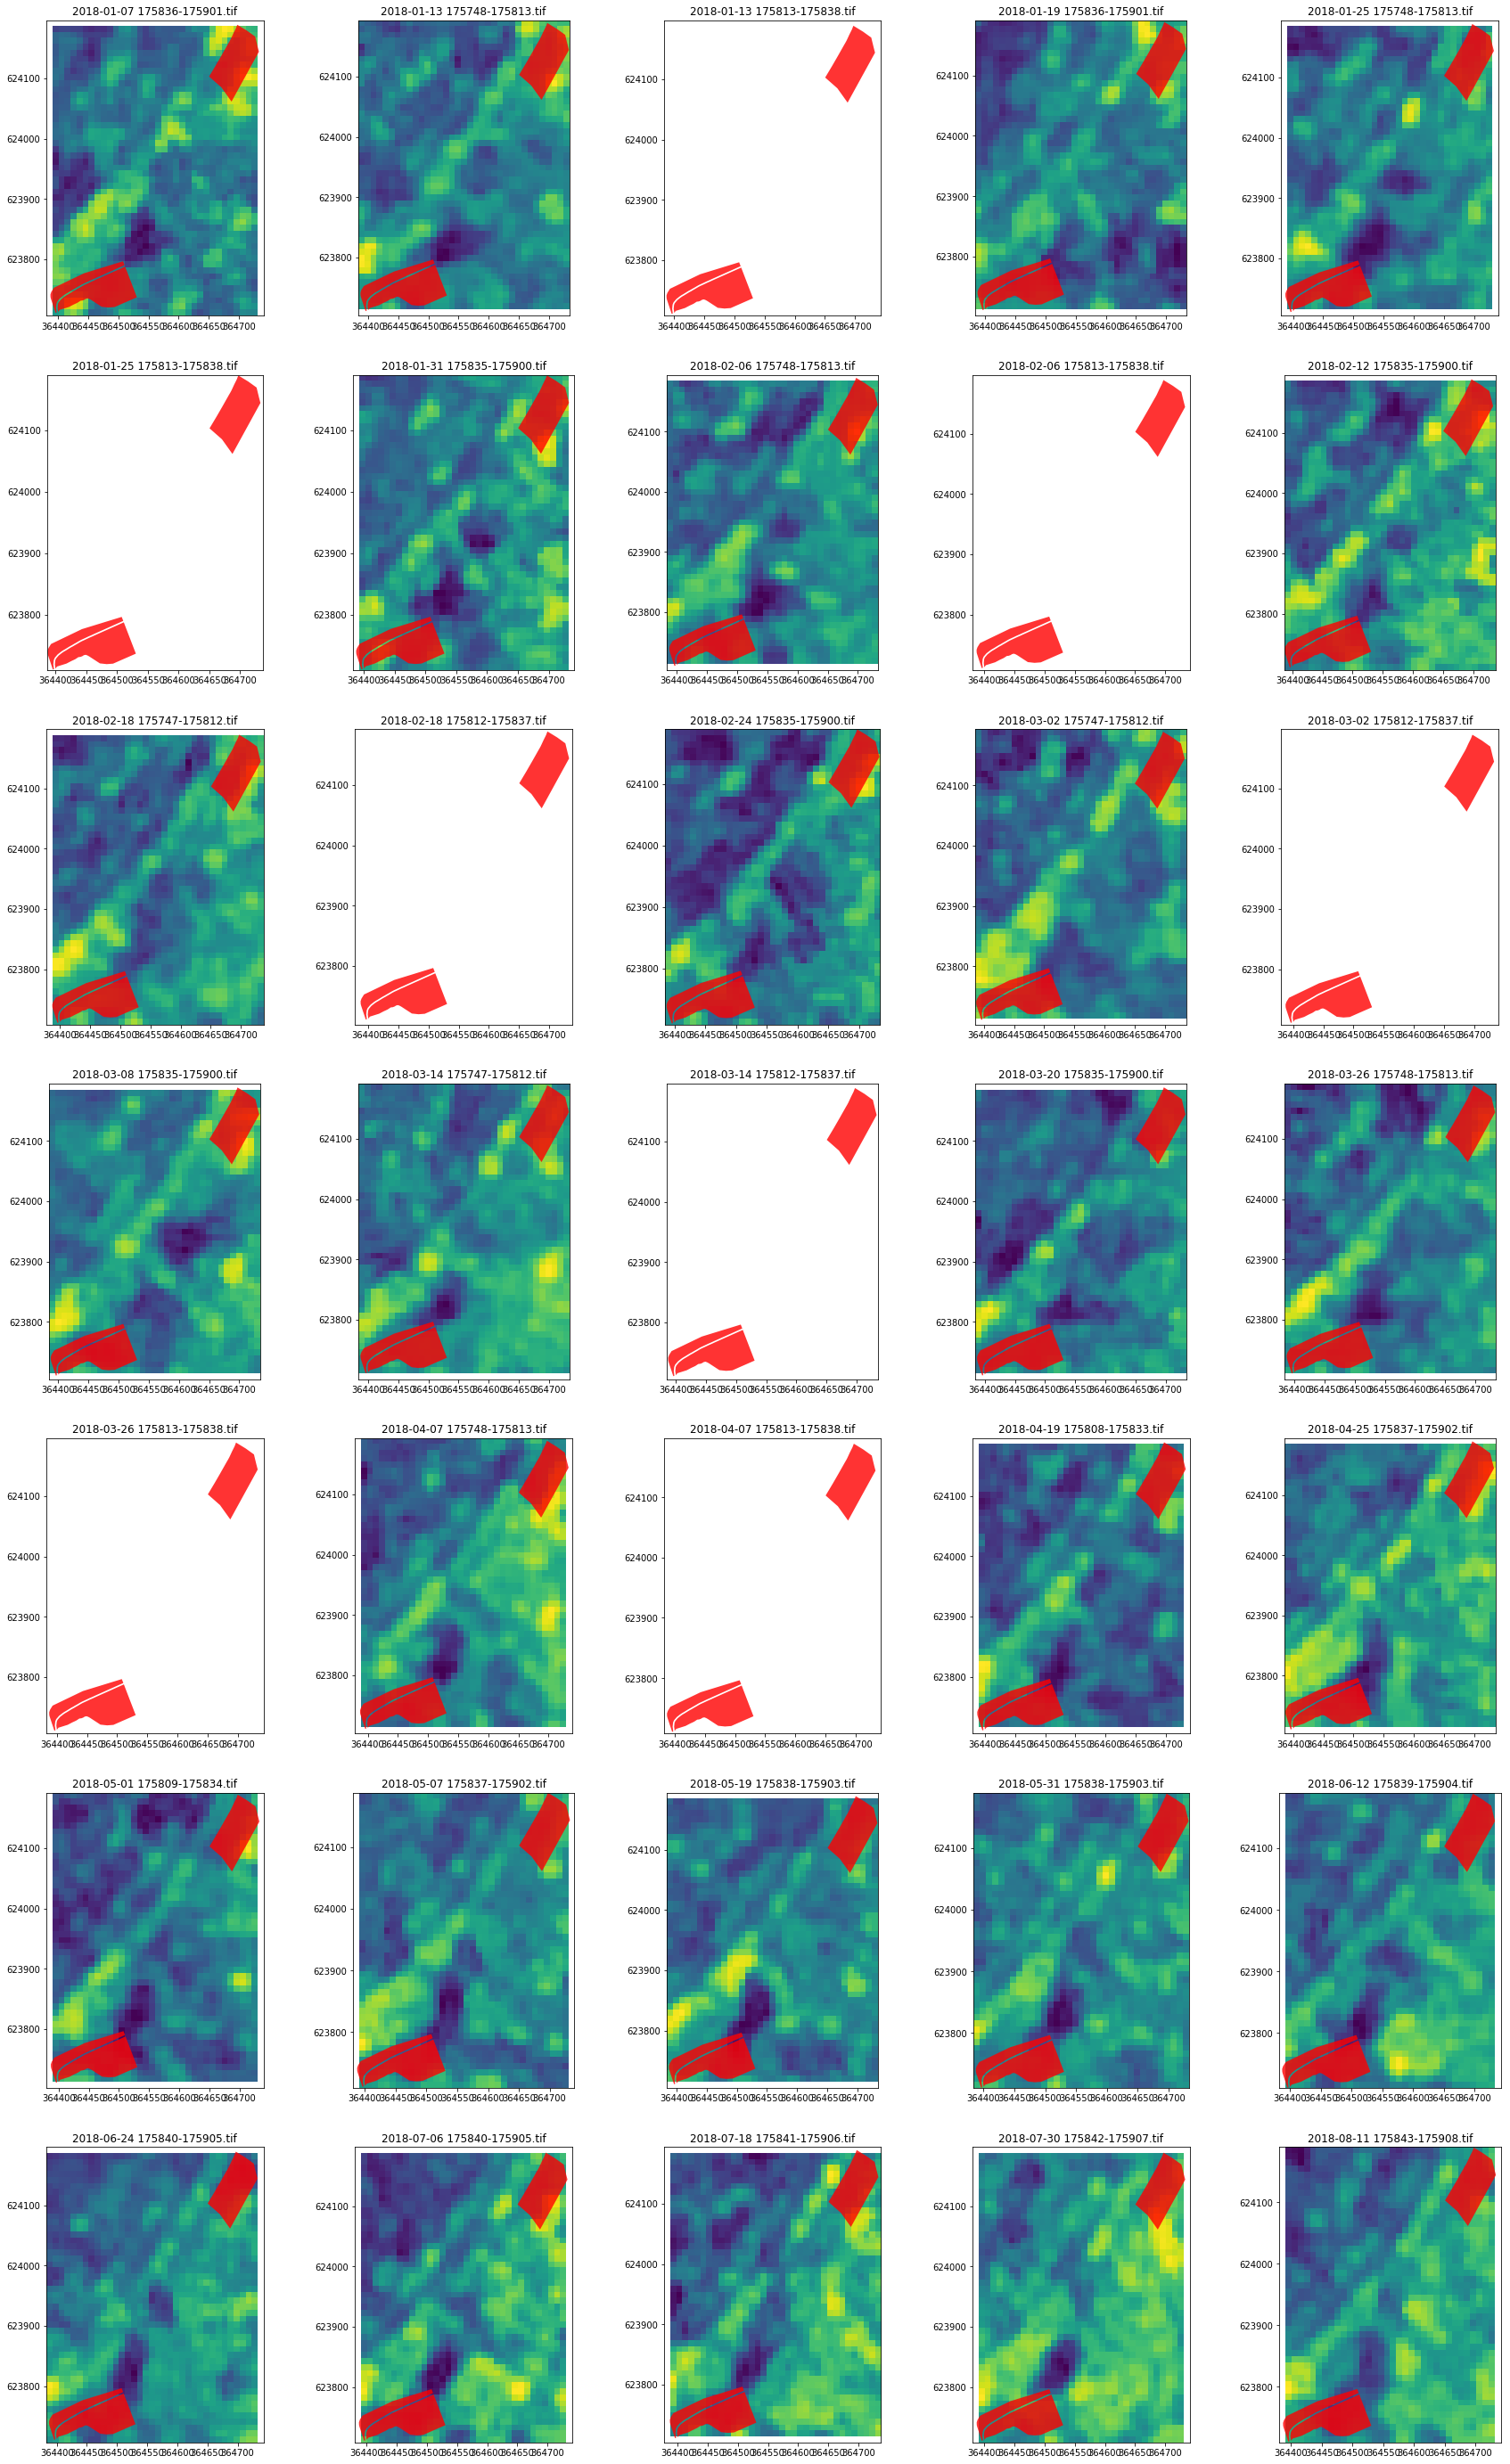

In [12]:
show_field_images(0)

http://data.cropmap.edina.ac.uk/clipped/fields/0//clipped_20180107_175836_175901.tif
http://data.cropmap.edina.ac.uk/clipped/fields/0//clipped_20180113_175748_175813.tif
http://data.cropmap.edina.ac.uk/clipped/fields/0//clipped_20180113_175813_175838.tif
http://data.cropmap.edina.ac.uk/clipped/fields/0//clipped_20180119_175836_175901.tif
http://data.cropmap.edina.ac.uk/clipped/fields/0//clipped_20180125_175748_175813.tif
http://data.cropmap.edina.ac.uk/clipped/fields/0//clipped_20180125_175813_175838.tif
http://data.cropmap.edina.ac.uk/clipped/fields/0//clipped_20180131_175835_175900.tif
http://data.cropmap.edina.ac.uk/clipped/fields/0//clipped_20180206_175748_175813.tif
http://data.cropmap.edina.ac.uk/clipped/fields/0//clipped_20180206_175813_175838.tif
http://data.cropmap.edina.ac.uk/clipped/fields/0//clipped_20180212_175835_175900.tif
http://data.cropmap.edina.ac.uk/clipped/fields/0//clipped_20180218_175747_175812.tif
http://data.cropmap.edina.ac.uk/clipped/fields/0//clipped_2018021

IndexError: index 7 is out of bounds for axis 0 with size 7

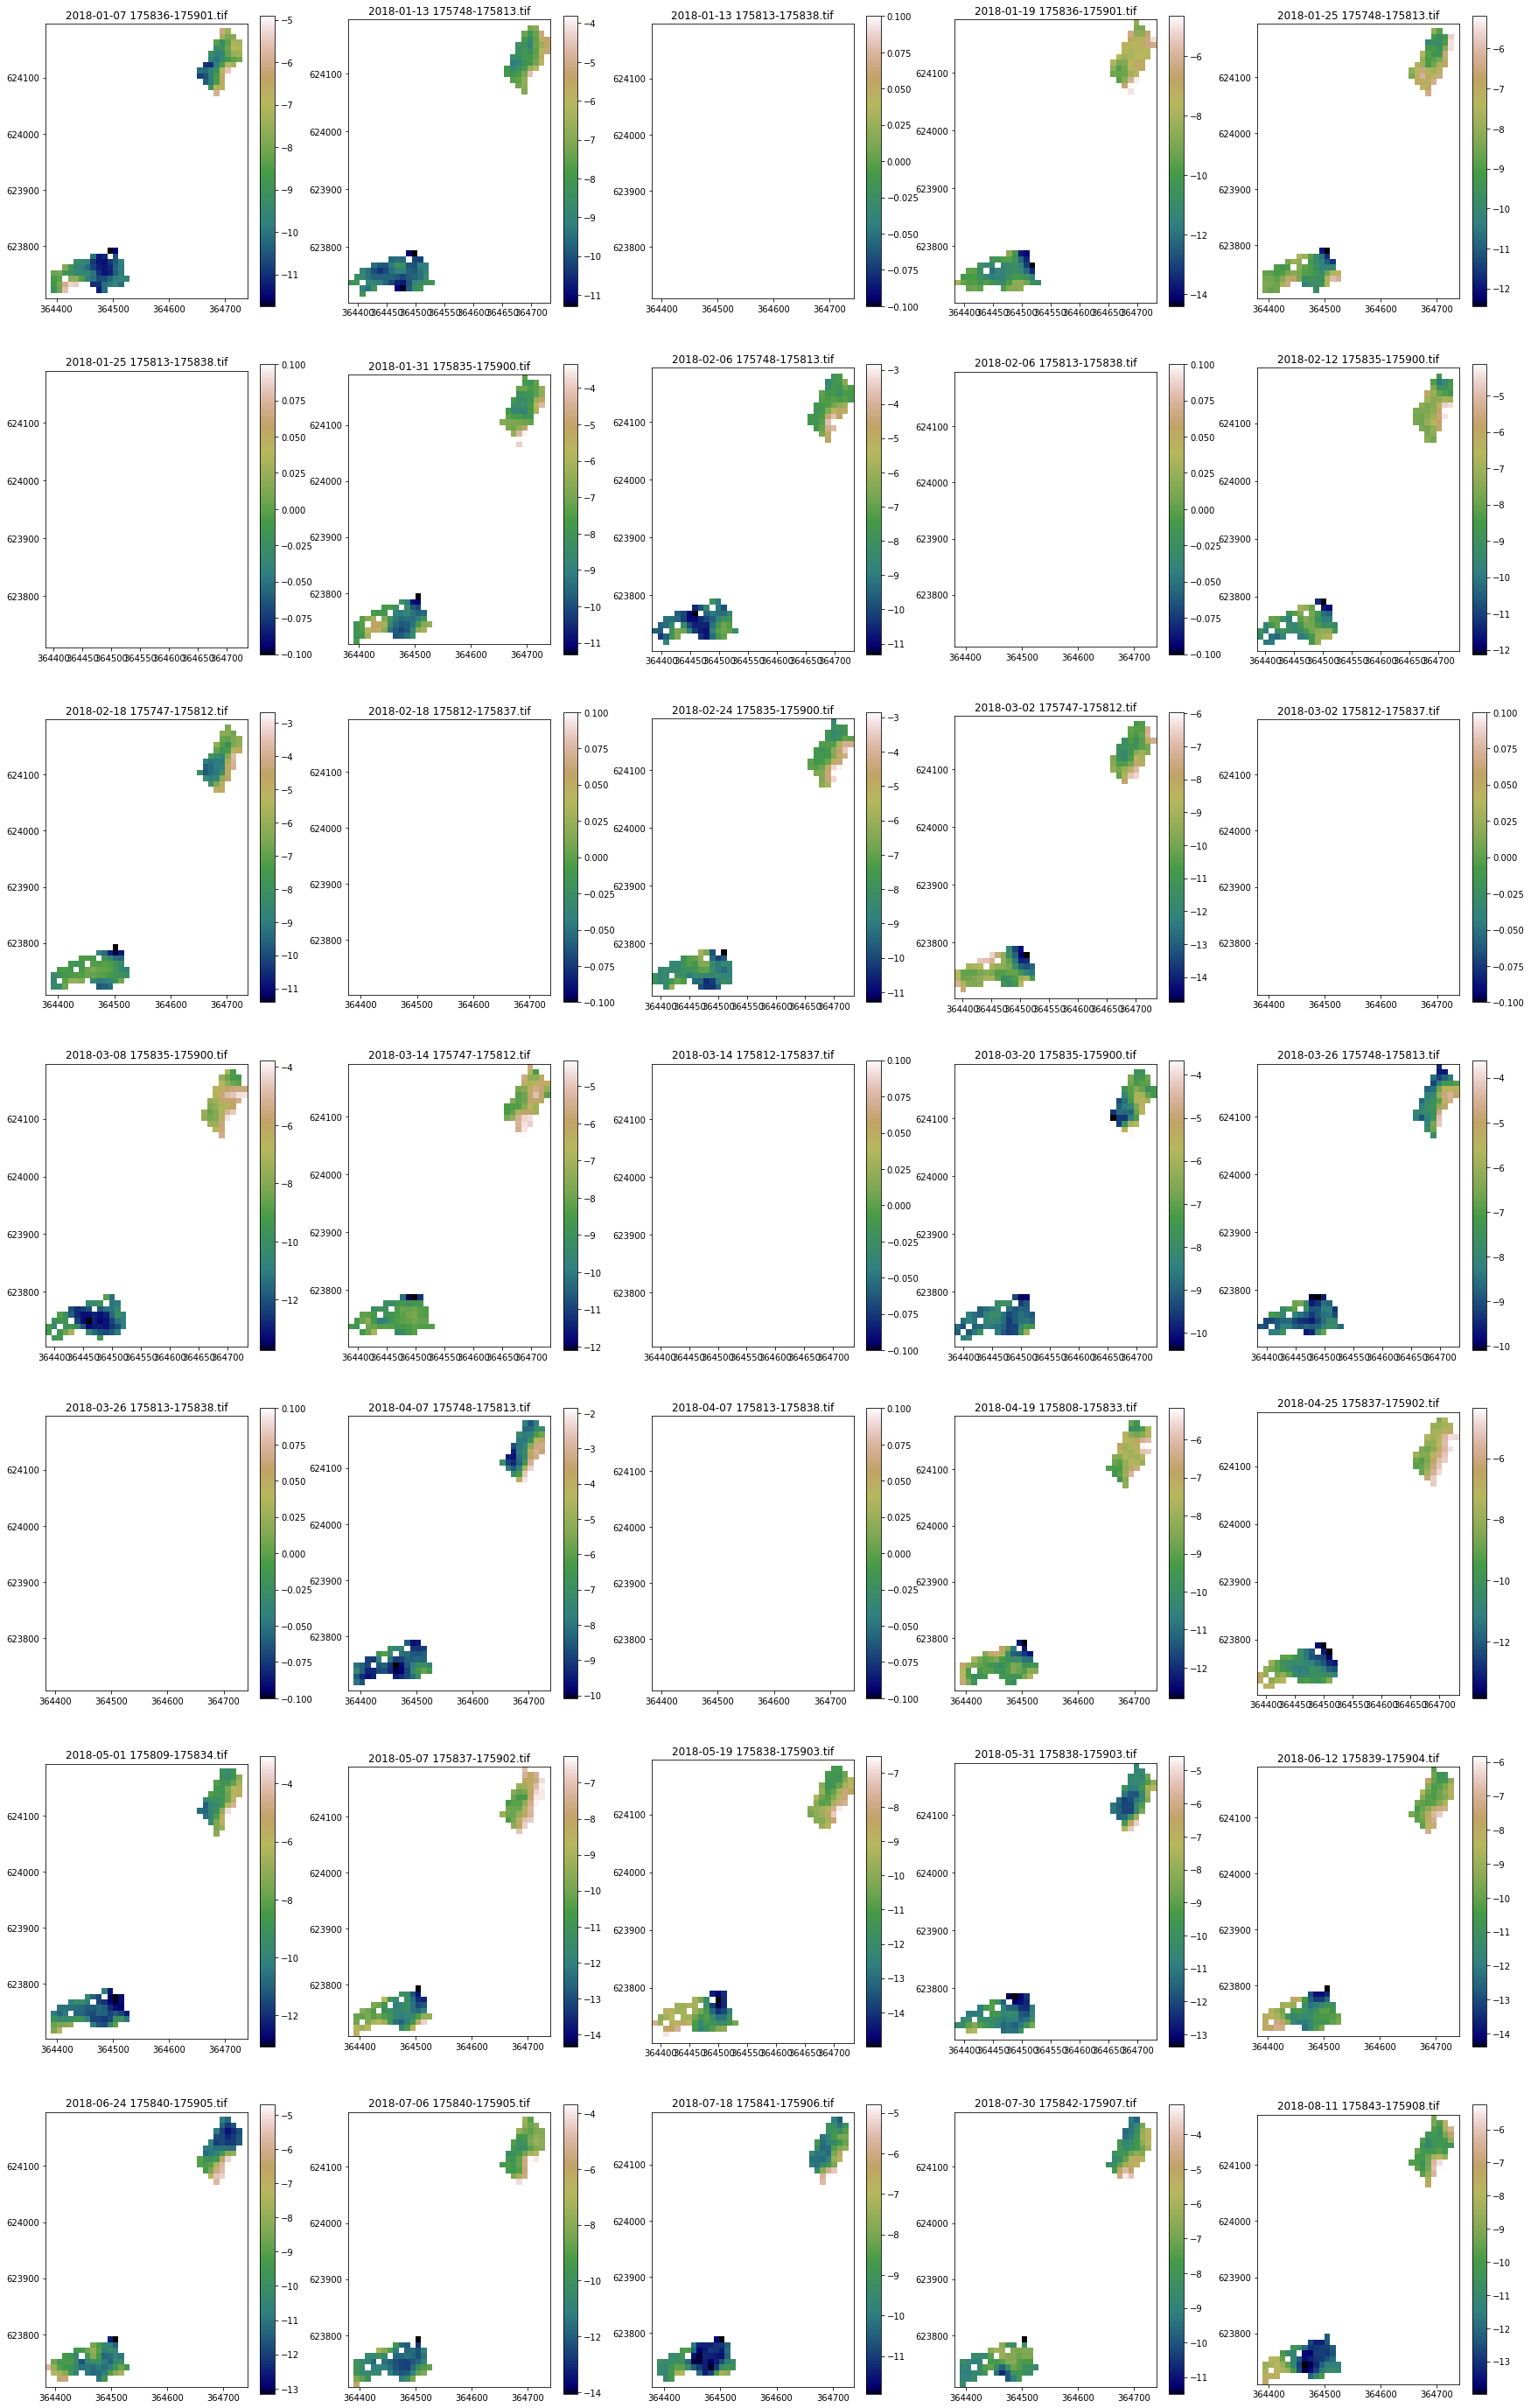

In [14]:
show_field_images(0, 'crop')

### Create on area clipped file

In [118]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

url = 'http://data.cropmap.edina.ac.uk/2018'
month = '01'
day = '13'
filename = 'S1B_20180113_30_asc_175748_175813_DV_Gamma-0_GB_OSGB_RCTK_SpkRL'
file = "{0}/{1}/{2}/{3}/{3}.tif".format(url,month,day,filename)
output_file = "clipped_{}.tif".format(filename)
ext = 'tif'

# Create Bbox
minx, miny = 361044.2,619013.4 
maxx, maxy = 383132.1,635928.0
bbox = box(minx, miny, maxx, maxy)

data = rasterio.open(file)
geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(27700))
geo = geo.to_crs(crs=data.crs.data)

coords = getFeatures(geo)
print("\n coords: "+str(coords))

out_img, out_transform = mask(data, shapes=coords, crop=True)

out_meta = data.meta.copy()
print("\n out_meta: "+str(out_meta))

epsg_code = int(data.crs.data['init'][5:])
print("\n epsg_code: "+str(epsg_code))

out_meta.update({"driver": "GTiff",
                 "height": out_img.shape[1],
                 "width": out_img.shape[2],
                 "transform": out_transform,
                 "crs": pycrs.parse.from_epsg_code(epsg_code).to_proj4()}
               )

# write clipped file
with rasterio.open(r"data/clipped/area/"+output_file, "w", **out_meta) as dest:
    dest.write(out_img)


 coords: [{'type': 'Polygon', 'coordinates': [[[383132.1, 619013.4000000013], [383132.1, 635928.0000000001], [361044.1999999998, 635927.999999999], [361044.1999999998, 619013.4], [383132.1, 619013.4000000013]]]}]

 out_meta: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 29713, 'height': 21931, 'count': 2, 'crs': CRS.from_dict(init='epsg:27700'), 'transform': Affine(10.0, 0.0, 161983.49413681764,
       0.0, -10.0, 653953.3094556708)}

 epsg_code: 27700
